Run CCC analysis using LIANA+Tensorcell2cell to analyse communication between T cells (except gd) and DCs in the ABC, DT_ABC, and aCD4_ABC contexts

TODO: if LR pairs popping up don't make sense, tune specificity filter (maybe don't use) as well as the lr_fill (use NaN)

In [1]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
    gpu_use = F
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
    gpu_use = T
}

library(reticulate, quietly = T)
if (gpu_use){
    device<-'cuda:0'
    tensorly <- reticulate::import('tensorly')
    tensorly$set_backend('pytorch')
}else{
    device<-NULL
}

n.cores<-30
env_name = 'norcross_abc'

In [2]:
suppressPackageStartupMessages({
    suppressWarnings({
        library(liana, quietly = T)
        library(decoupleR, quietly = T)

        library(Seurat, quietly = T)
        
        library(dplyr, quietly = T)
        library(tidyr, quietly = T)
        library(magrittr, quietly = T)
        library(tibble, quietly = T)
        library(stringr)
        
        library(ggplot2, quietly = T)
        
#         c2c <- reticulate::import(module = "cell2cell", as="c2c")
    })
})

In [190]:
filter_specificity = FALSE # whether to filter scores by aggregate specificity score
filter_str = ''
if (filter_specificity){
    filter_thresh = 0.05 # analogous to a p-value
}

In [3]:
abc.integrated<-readRDS(paste0(data_path, 'processed/abc_annotated.RDS'))

Subset to the cell types and contexts of interest:

In [4]:
cell.types<-c('T-cells', 'cDC_1', 'cDC_2', 'Xcr1+ DC_1', 'Xcr1+ DC_2', 'pDC')
contexts<-c('ABC', 'DT_ABC', 'aCD4_ABC')
abc.ccc<-subset(abc.integrated, subset = (Cell.Type.Level1 %in% cell.types) & (Cell.Type.Level2 != 'gd-T') &
                                        (orig.ident %in% contexts))
Idents(abc.ccc)<-'Cell.Type.Level2'

Format to input to LIANA:

In [191]:
# format into sce object
DefaultAssay(abc.ccc)<-'RNA'
abc.ccc@meta.data <-abc.ccc@meta.data %>% droplevels()
abc.ccc.sce<-Seurat::as.SingleCellExperiment(abc.ccc)

In [6]:
# map LIANA consensus resource to mouse
suppressMessages({
    suppressWarnings({
        op_resource <- liana::select_resource("Consensus")[[1]]

        # Generate orthologous resource
        ortholog_resource <- liana::generate_homologs(op_resource = op_resource,
                                               target_organism = 10090) # mouse
    })
})

Run liana for each context and calculate the consensus rank score:

In [8]:
suppressWarnings({
    abc.ccc.sce<-liana_bysample(sce = abc.ccc.sce, 
               idents_col = 'Cell.Type.Level2', 
               sample_col = 'orig.ident',
               assay.type='logcounts', # log-normalized counts
               verbose = T, 
              aggregate_how = 'both', # consensus magnitude AND specifity score
                resource = 'custom', 
                external_resource = ortholog_resource, # consensus resource in mouse
               min_cells = 5, # default min cells to be considered
               expr_prop = 0.05, # expressed in atleast 5% of cells to be scored
               return_all = TRUE, # assign a low score to those that don't pass expr_prop
                parallelize = TRUE, workers = n.cores,
              )
})
saveRDS(abc.ccc.sce@metadata$liana_res, paste0(data_path, 'interim/', 'liana_bysample.rds'))

In [192]:
# abc.ccc.sce@metadata$liana_res<-readRDS(paste0(data_path, 'interim/', 'liana_bysample.rds'))

If filtering for specificity rank, will change # of interactions in the contexts as follows:

In [143]:
sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x)[[1]])
sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank > filter_thresh, ])[[1]])

ABC   DT_ABC aCD4_ABC 
  349650   458775   447750

ABC   DT_ABC aCD4_ABC 
  232738   305375   298036

In [144]:
# abc.ccc.sce@metadata$liana_res<-lapply(abc.ccc.sce@metadata$liana_res, 
#                                function(x) x[x$specificity_rank > filter_thresh, ])
if (filter_specificity){
    liana_res<-list()
    for (sample.name in names(abc.ccc.sce@metadata$liana_res)){
        x<-abc.ccc.sce@metadata$liana_res[[sample.name]]
        #x<-[x$specificity_rank > filter_thresh, ] # eliminate those under threshold
        x[x$specificity_rank > filter_thresh, 'magnitude_rank']<-max(x$magnitude_rank) # replace with "lowest" value (max because magnitude rank orders lower values as higher importance)
        abc.ccc.sce@metadata$liana_res[[sample.name]]<-x
    }
}

Run Tensor-cell2cell

In [193]:
abc.ccc.sce@metadata$liana_res<-liana:::preprocess_scores(context_df_dict = abc.ccc.sce@metadata$liana_res, 
                                 score_col = 'magnitude_rank', # score to preprocess
                                  outer_fraction = 1/3, # only keep cells/LRs present in atleast in 1/3 of contexts
                                                        # outer_fract shouldn't change things since there are only 3 samples
                                  invert = TRUE, # since magnitude has lower scores being more valuable
                                  invert_fun = function(x) 1-x, 
                                  non_negative = TRUE, # shouldn't effect things since all magnitude ranks are positive
                                  non_negative_fill = 0, 
                                  verbose = T
                                 )

Inverting `magnitude_rank`!

Inverting `magnitude_rank`!

Inverting `magnitude_rank`!



In [194]:
score_col = 'magnitude_rank'
min.score<-min(sapply(abc.ccc.sce@metadata$liana_res, function(x) min(x[[score_col]])))
min.score

[1] 0

In [195]:
# build tensor
tensor <- liana::liana_tensor_c2c(sce = abc.ccc.sce,
                                  context_df_dict = NULL, 
                                  score_col = 'magnitude_rank', 
                                  how = 'outer', 
                                  lr_fill = min.score, 
                                  cell_fill = 0, 
                                  context_order = levels(abc.ccc.sce@colData$orig.ident), 
                                  sort_elements = TRUE, 
                                  conda_env = env_name, 
                                  build_only = TRUE, 
                                  device = device)

Warning message in exec(output, ...):
“`sce` was superseded by `context_df_dict`!”


[1] 0


Loading `norcross_abc` Conda Environment

Building the tensor using magnitude_rank...



In [196]:
# decompose tensor
tensor<-liana::decompose_tensor(tensor = tensor, 
                         rank = NULL, 
                         tf_optimization = 'regular', # CHANGE TO ROBUST
                         elbow_metric = 'error', # Metric to use in the elbow analysis.
                         smooth_elbow = FALSE, # Whether smoothing the metric of the elbow analysis.
                         upper_rank=25, # Max number of factors to try in the elbow analysis
                         init = 'svd', # Initialization method of the tensor factorization
                         factors_only = FALSE, 
                        )
saveRDS(tensor, paste0(data_path, 'processed/', 'ccc_tensor.rds'))

Estimating ranks...

Decomposing the tensor...



# Downstream Analysis

In [238]:
# basic formatting
factors<-liana:::format_c2c_factors(tensor$factors)

# ordering categories
f.c<-factors$contexts
f.c[['context']]<-factor(f.c$context, levels(abc.ccc.sce@colData$orig.ident))
factors[['contexts']]<-f.c
for (ct in c('senders', 'receivers')){
    f.ct<-factors[[ct]]
    f.ct[['celltype']]<-factor(f.ct$celltype, levels(abc.ccc.sce@colData$Cell.Type.Level2))
    factors[[ct]]<-f.ct
}
abc.ccc.sce@metadata$tensor_res<-factors

abc.ccc.sce@colData[['group']] = abc.ccc.sce@colData[['orig.ident']] # must have a "group" for plotting

[1] "The identified tensor rank is 4"


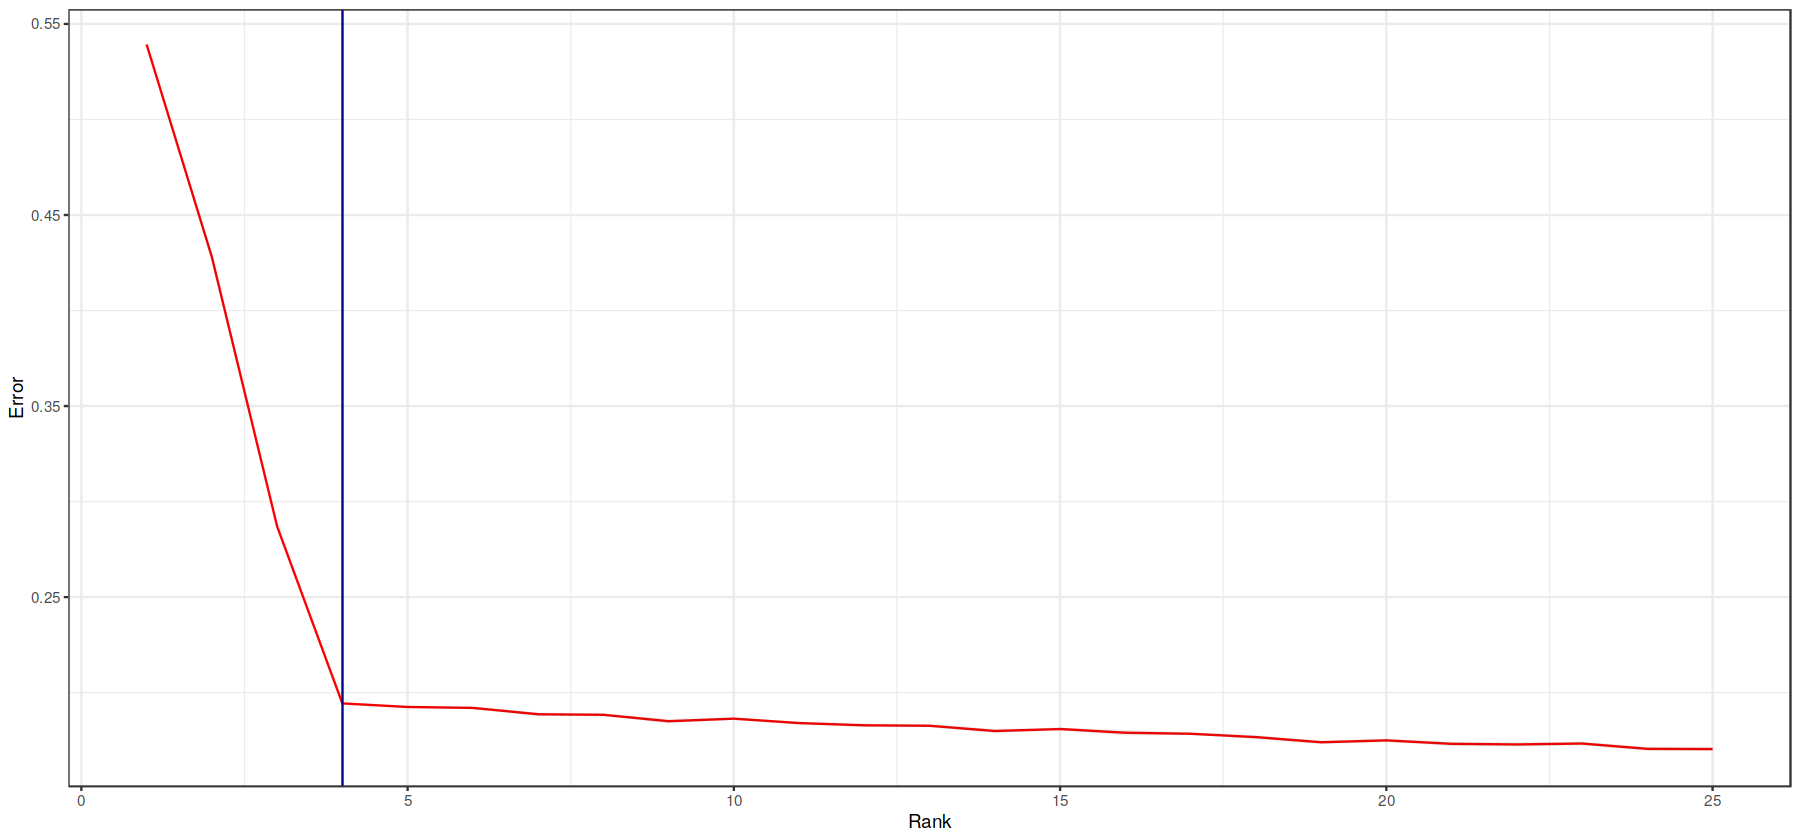

In [208]:
print(paste0('The identified tensor rank is ', tensor$rank))

# Estimate standard error
error_average <- tensor$elbow_metric_raw %>%
    t() %>%
    as.data.frame() %>%
    mutate(rank=row_number()) %>% 
    pivot_longer(-rank, names_to = "run_no", values_to = "error") %>%
    group_by(rank) %>%
    summarize(average = mean(error),
              N = n(),
              SE.low = average - (sd(error)/sqrt(N)),
              SE.high = average + (sd(error)/sqrt(N))
           )

# plot
error_average %>%
    ggplot(aes(x=rank, y=average), group=1) +
    geom_line(col='red') + 
    geom_ribbon(aes(ymin = SE.low, ymax = SE.high), alpha = 0.1) +
    geom_vline(xintercept = tensor$rank, colour='darkblue') + # rank of interest
    theme_bw() +
    labs(y="Error", x="Rank")

In [199]:
# addapt from liana
plot_c2c_overview <- function(sce, group_col, sample_col){

    factors <- get_c2c_factors(sce, group_col, sample_col)

    # Contexts
    contexts <- factors$contexts %>%
        pivot_longer(cols = -c("context", group_col),
                     names_to = "factor", values_to = "loadings"
        ) %>%
        ggplot(aes(x=context, y=loadings, fill=.data[[group_col]])) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ggtitle('Contexts') +
        ylab(NULL)

    # lr
    lr <- factors$interactions %>%
        pivot_longer(-lr, names_to = "factor", values_to = "loadings") %>%
        ggplot(aes(x=lr, y=loadings)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ ., scales = "free_y") +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.background = element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ggtitle('Interactions') +
        ylab(NULL)


    # Sender cells
    senders <- factors$senders %>%
        pivot_longer(cols = -celltype,
                     names_to = "factor", values_to = "loadings"
        ) %>%
        ggplot(aes(x=celltype, y=loadings,
                   fill=celltype)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.background = element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ylab(NULL) +
        ggtitle('Senders')

    # Receiver cells
    receivers <- factors$receivers %>%
        pivot_longer(cols = -celltype,
                     names_to = "factor", values_to = "loadings"
        ) %>%
        ggplot(aes(x=celltype, y=loadings,
                   fill=celltype)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              strip.background = element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.y = element_text(size=15, face = "bold"),
              plot.title = element_text(hjust = 0.5)) +
        ylab(NULL) +
        ggtitle('Receivers')

    # Assemble overview plot
    overview <- patchwork::wrap_plots(list(contexts,
                                           lr,
                                           senders,
                                           receivers
    ),
    ncol=4,
    nrow(1)) +
        patchwork::plot_layout(guides = "collect")

    grid::grid.draw(overview)
}

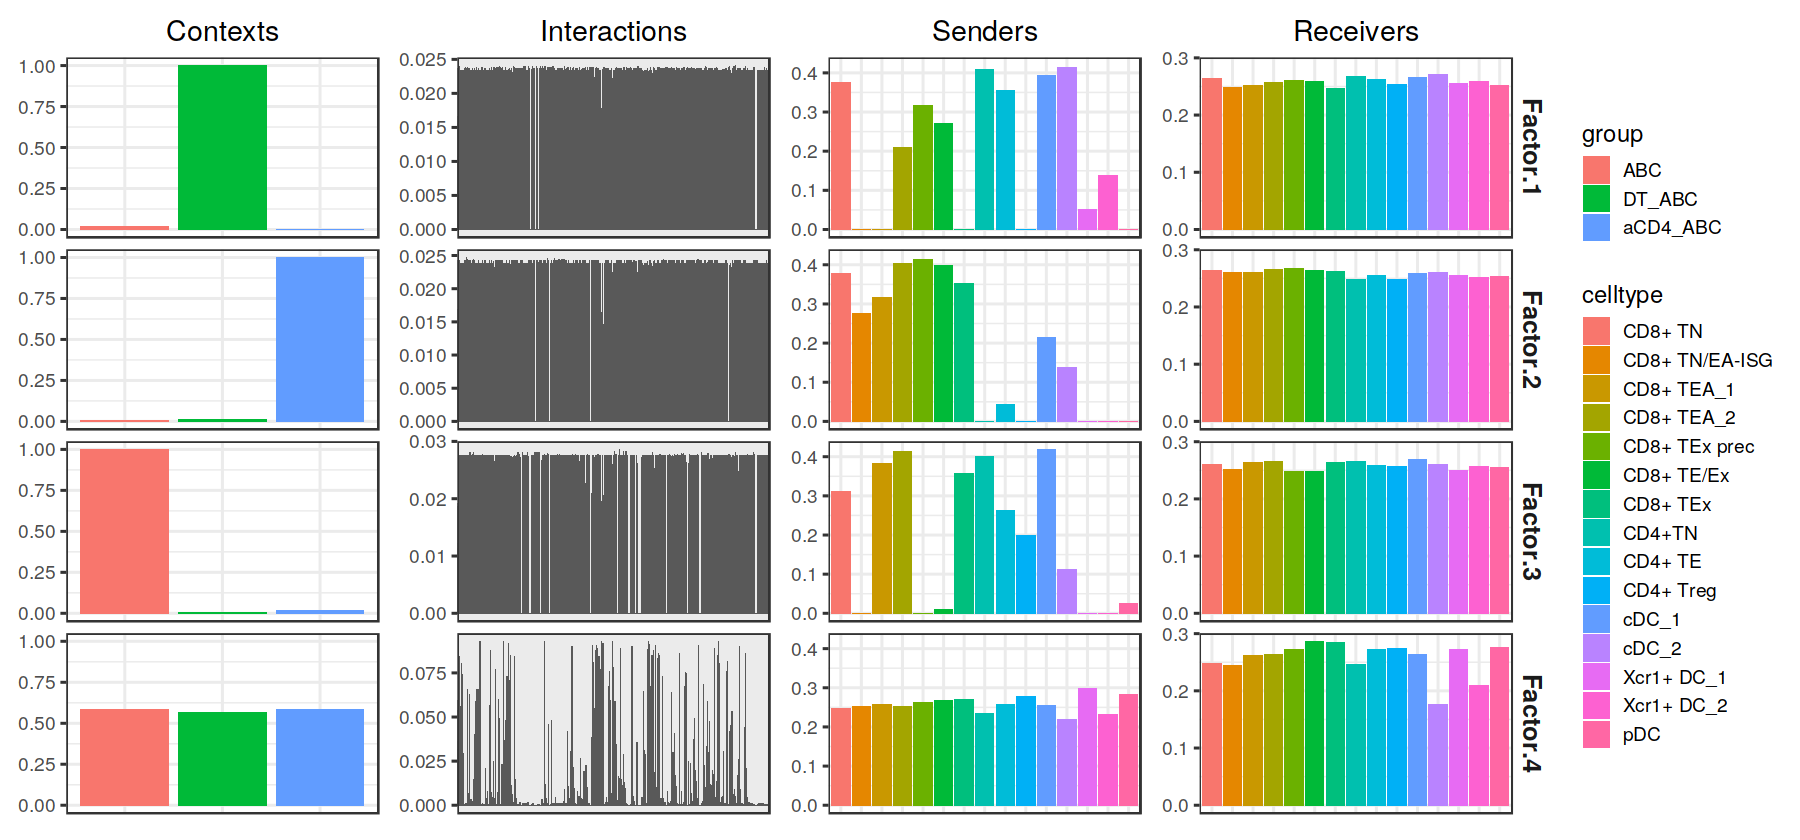

In [239]:
h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

plot_c2c_overview(sce = abc.ccc.sce, group_col = 'group', sample_col = 'orig.ident')

General conclusions: 3 of the 4 factors (Factors 1-3) represent a single-context specific communication pattern. Receivers tend to be non-specific, whereas senders seem to be specific to a given context. cDCs are the main DC involved in a context-specific manner as senders. However, in a context-independent manner (Factor 4) as senders and as receivers across all Factors all DCs are clearly participating in communication. 

Some interesting sender + context-specific results: CD8 ISG seems specific to aCD4_ABC, TEA_1 is not active in DT_ABC but is in the other two contexts (though this may not align with trajectory analysis results), exhausted CD8s are active as senders in DT_ and aCD4_ABC but not as much in ABC (except TEx), no Tex in aCD4_ABC, some Xcr1 activity in aCD4_ABC but not the other two conditions.  

One unexpected result is that, in the single-context factors, many of the LRs seem to be equally participating (and lower loading values than Factor 4), indicating that perhaps the interactions that are more heavily LR-specific are associated with all contexts and cell types, whereas more subtle differences in which sender cells are expressing LRs dominate Factors 1-3. This may make the results less meaningful. This can also be seen in a heatmap of the LR loadings, where the context-specific factor loadings are weaker and also show substantial overlap:

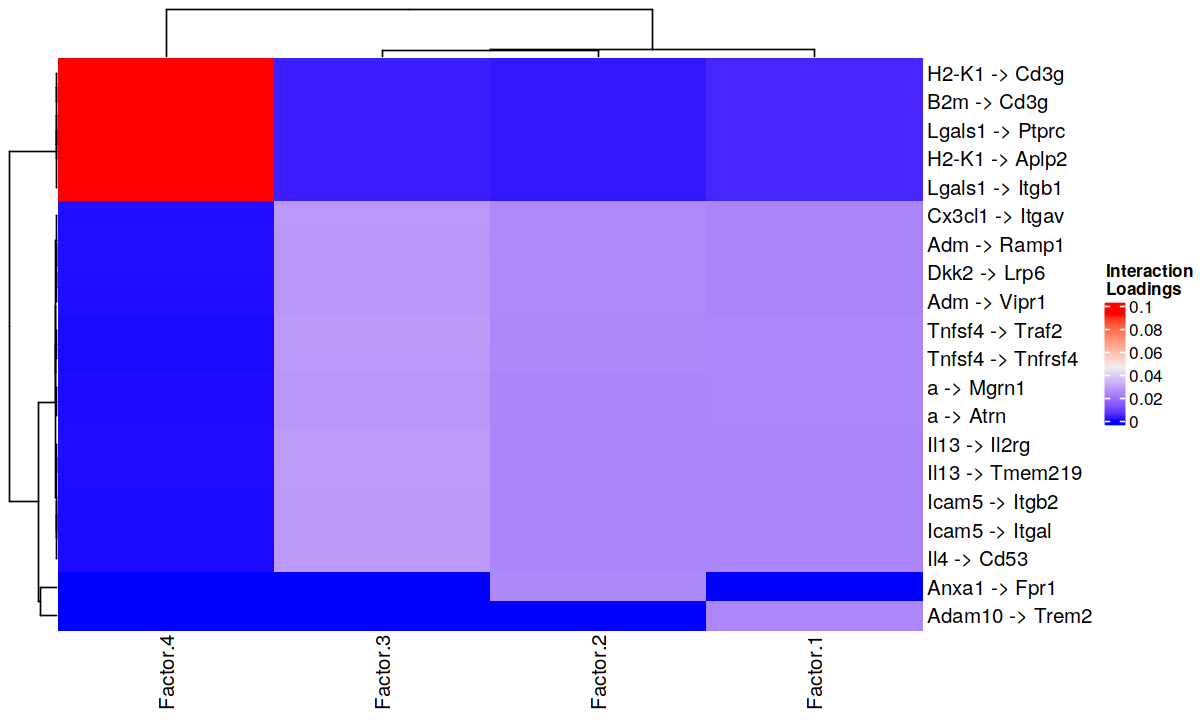

In [240]:
h_ = 6
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)
liana::plot_lr_heatmap(sce = abc.ccc.sce,  n = 5)

Though, by increasing the # of LRs we visualize, we can see some Factor-specific LR blocks for Factors 1-3 as well: 

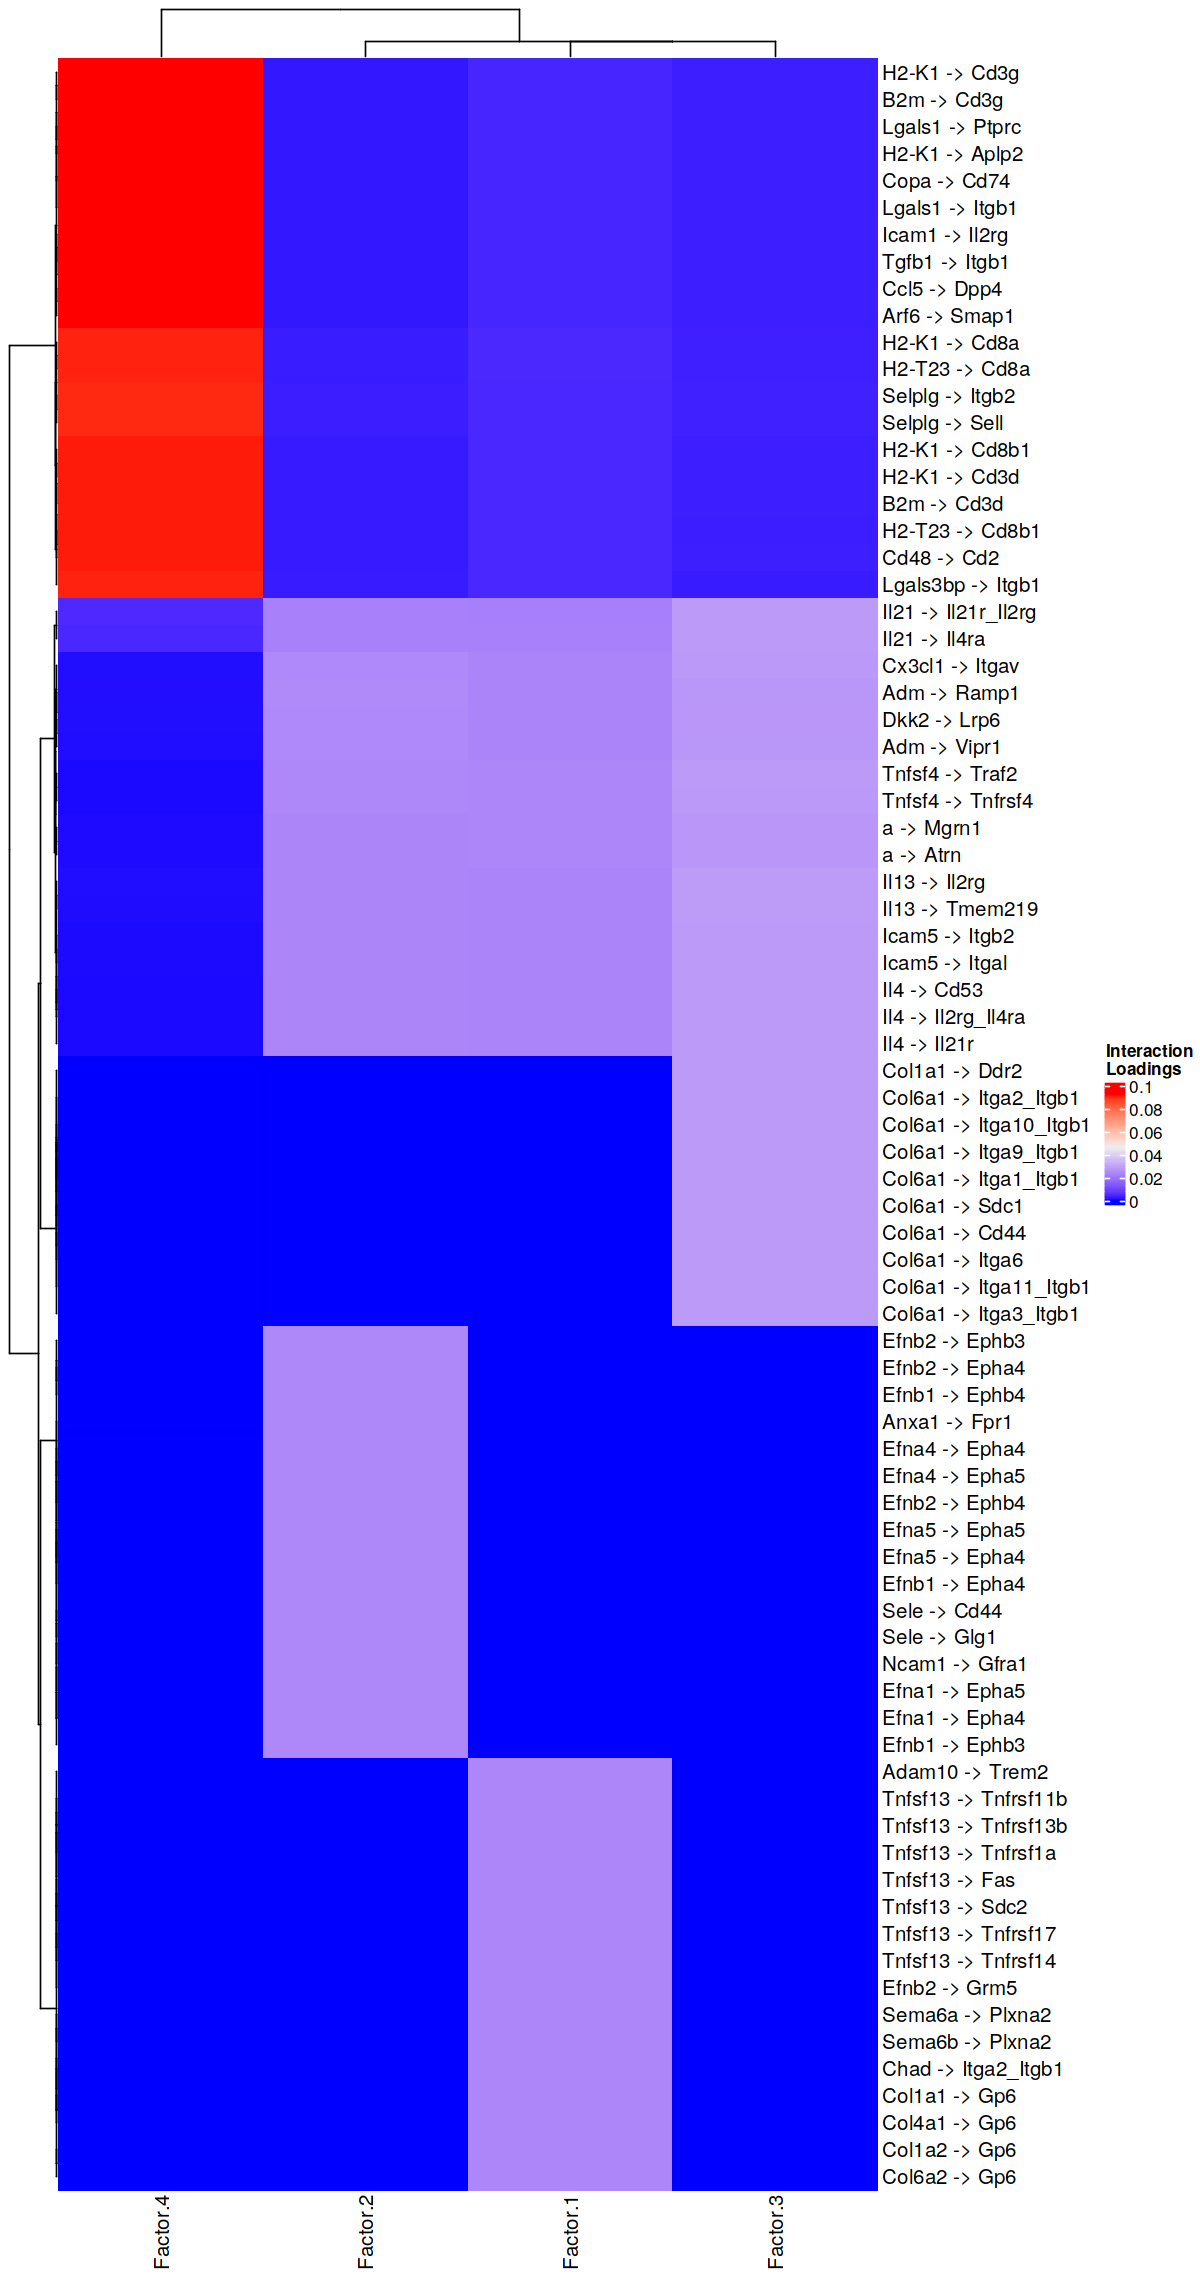

In [241]:
h_ = 19
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)
liana::plot_lr_heatmap(sce = abc.ccc.sce,  n = 20)

In [242]:
top_lrs = list()
for (i in 1:3){
    factor.name<-paste0('Factor ', i)
    top_lrs[[factor.name]] = tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(10))
}
top_lrs


$`Factor 1`
          a^Mgrn1            a^Atrn    Tnfsf4^Tnfrsf4      Tnfsf4^Traf2 
       0.02408760        0.02404266        0.02403474        0.02401339 
     Adam10^Trem2 Tnfsf13^Tnfrsf11b Tnfsf13^Tnfrsf13b  Tnfsf13^Tnfrsf1a 
       0.02391956        0.02391823        0.02391816        0.02391809 
      Tnfsf13^Fas      Tnfsf13^Sdc2 
       0.02391801        0.02391795 

$`Factor 2`
   Adm^Ramp1    Dkk2^Lrp6 Cx3cl1^Itgav    Adm^Vipr1   Anxa1^Fpr1  Ncam1^Gfra1 
  0.02470076   0.02454625   0.02448166   0.02442963   0.02433631   0.02433284 
   Sele^Glg1    Sele^Cd44  Efna1^Epha4  Efna1^Epha5 
  0.02433208   0.02433195   0.02433190   0.02433079 

$`Factor 3`
    Il13^Tmem219       Il13^Il2rg         Il4^Cd53      Icam5^Itgb2 
      0.02860271       0.02860257       0.02822014       0.02819344 
     Icam5^Itgal Il21^Il21r_Il2rg  Il4^Il2rg_Il4ra        Il4^Il21r 
      0.02819029       0.02818158       0.02817217       0.02816648 
    Tnfsf4^Traf2      Col1a1^Ddr2 
      0.02814029       0.02812071

There is apparently some noise in the database, as can be seen from ligands names "a"

Overall, it is worth most specifically exploring differences in the sender cells for the context-specific Factors, after which we can focus on specific LRs involved

For each context-specific factor, let's look at how the senders are interacting with teh receivers in more detail:

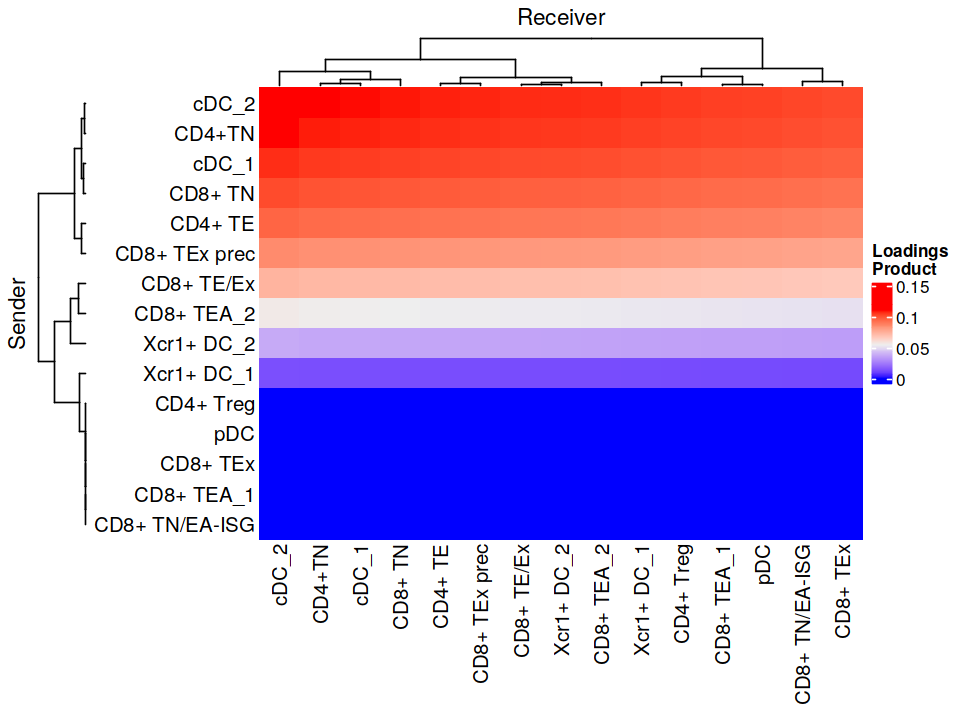

In [245]:
h_ = 6
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)
selected_factor<-'Factor.1'
liana::plot_c2c_cells(sce = abc.ccc.sce,
                   factor_of_int = selected_factor,
                   name = "Loadings \nProduct") + ggtitle(selected_factor)

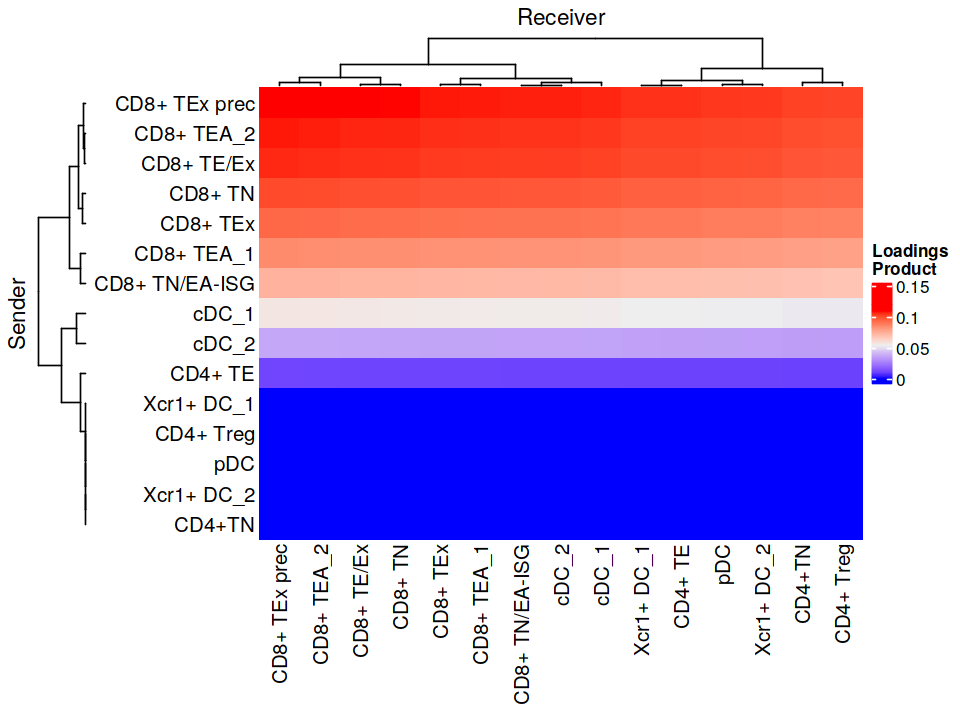

In [246]:
selected_factor<-'Factor.2'
liana::plot_c2c_cells(sce = abc.ccc.sce,
                   factor_of_int = selected_factor,
                   name = "Loadings \nProduct") + ggtitle(selected_factor)

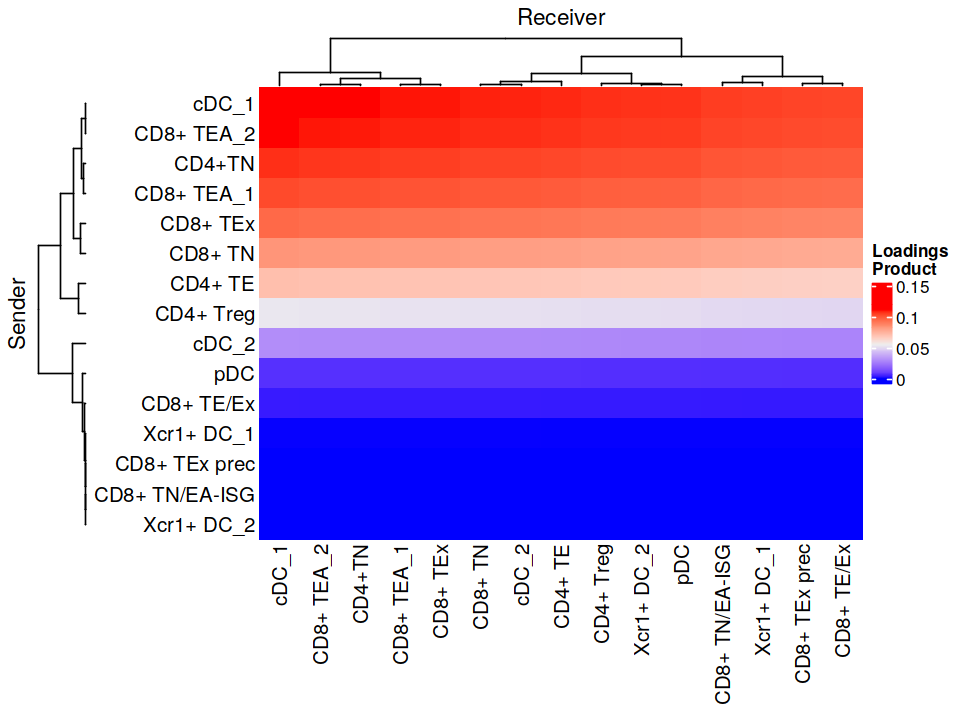

In [247]:
selected_factor<-'Factor.3'
liana::plot_c2c_cells(sce = abc.ccc.sce,
                   factor_of_int = selected_factor,
                   name = "Loadings \nProduct") + ggtitle(selected_factor)

Since the receivers are pretty homozygous, this doesn't give us too much more information than the Factor Plots themselves.

Finally, let's do an enrichment of the LRs for each of the context-specific Factors:

**Need to fine tune these results, doesn't make sense**: maybe try a regular GSEA rather than a progeny one. Right now, more than half the LRs are not assigned to a pathway

In [252]:
# obtain progeny gene sets
progeny <- decoupleR::get_progeny(organism = 'mouse', top=5000) %>%
    select(-p_value)

# convert to LR sets
progeny_lr <- generate_lr_geneset(sce = abc.ccc.sce,
                                  resource = progeny)

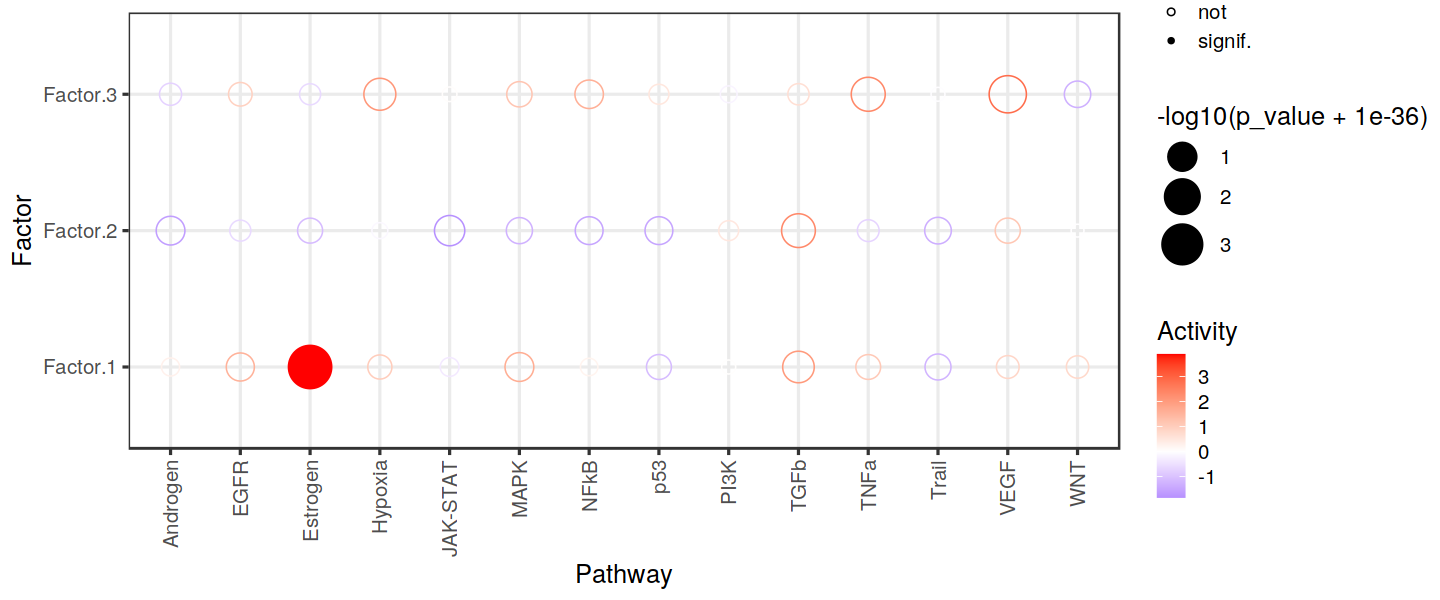

In [257]:
h_ = 5
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

# interaction loadings to matrix
fos<-c('Factor.1', 'Factor.2', 'Factor.3')
mat <- factors$interactions[, c('lr', fos)] %>%
    column_to_rownames("lr") %>%
  as.matrix()

# run enrichment analysis with decoupler
# (we fit a univariate linear model for each gene set)
# We don't consider genesets with minsize < 10
res <- decoupleR::run_ulm(mat = mat,
                          network = progeny_lr,
                          .source = "set",
                          .target = "lr",
                          minsize=10) %>%
  mutate(p_adj = p.adjust(p_value, method = "fdr"))

res %>% # sig/isnig flag
  mutate(significant = if_else(p_adj <= 0.1, "signif.", "not")) %>%
  ggplot(aes(x=source, y=condition, shape=significant,
             colour=score, size=-log10(p_value+1e-36))) +
  geom_point() +
  scale_colour_gradient2(high = "red", low="blue") +
  scale_size_continuous(range = c(3, 12)) +
  scale_shape_manual(values=c(21, 16)) +
  theme_bw(base_size = 15) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  labs(x="Pathway",
       y="Factor",
       colour="Activity"
       )

In [261]:
progeny_lr[(progeny_lr$set == 'Estrogen') & (progeny_lr$mor > 0), ]

lr,set,mor
<chr>,<chr>,<dbl>
Ado^Adora1,Estrogen,2.7689881
C3^C5ar2,Estrogen,3.2558355
C3^Cd19,Estrogen,1.0540428
C3^Cr2,Estrogen,1.1949462
Cdh1^Igf1r,Estrogen,1.5148409
Col18a1^Itgb5,Estrogen,1.1638492
Fgf18^Fgfr3,Estrogen,1.4328506
Fgf23^Fgfr3,Estrogen,1.1412752
Impg2^Prlr,Estrogen,0.6692211


Warning message in left_join(., progeny_lr, by = "lr"):
“Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 9 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning.”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


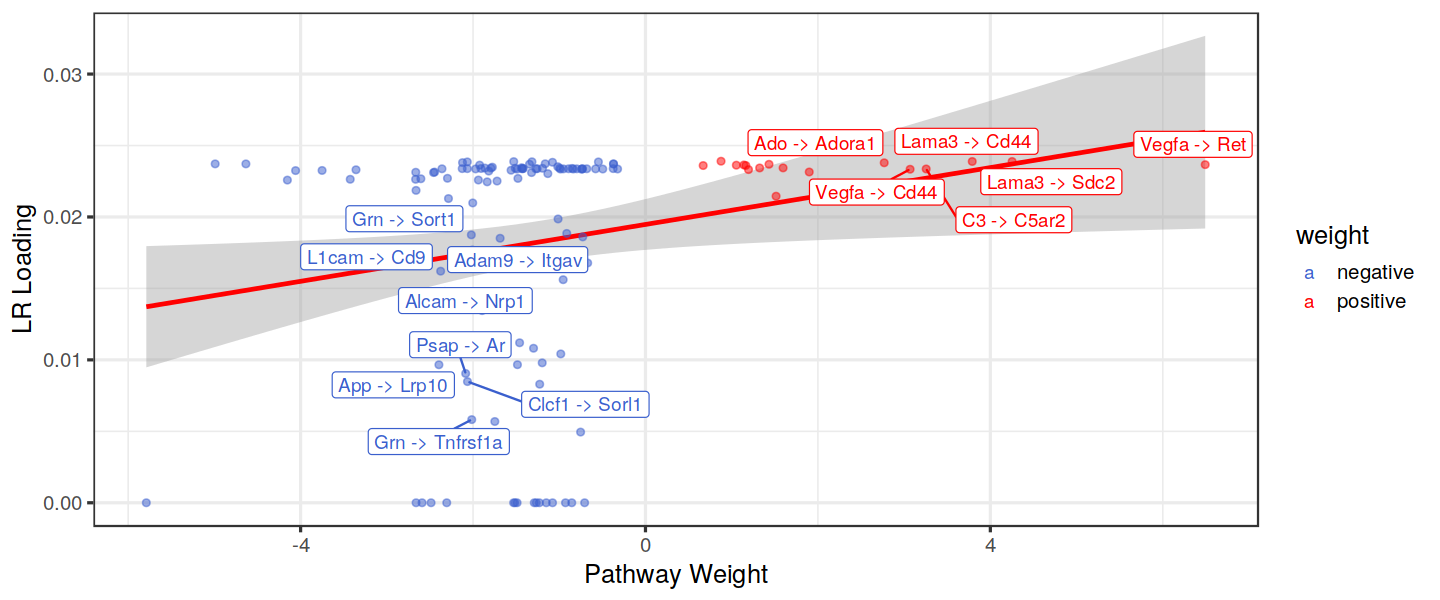

In [272]:
pathway = 'Estrogen'
factor = 'Factor.1'
# Plot LRs associated with Estrogen
lrs <-  factors$interactions %>%
  left_join(progeny_lr, by="lr") %>%
  filter(set==pathway) %>%
  select(lr, set, mor, loading = factor) %>%
  mutate(lr = gsub(as.character(str_glue("\\^")), " -> ", lr)) %>%
  mutate(weight = if_else(mor >= 0, "positive", "negative"))
lrs %>%
  # only label those that are > x
  mutate(lr = if_else(loading>=0.001 & abs(mor) > 2, lr, "")) %>%
  ggplot(aes(x=mor, y=loading, colour=weight)) +
  # label only top 20
  stat_smooth(method = "lm", col = "red") +
  geom_point(alpha = 0.5) + 
  ggrepel::geom_label_repel(aes(label = lr)) +
  theme_bw(base_size = 15) +
  scale_colour_manual(values = c("royalblue3", "red")) +
  labs(x="Pathway Weight", y="LR Loading")